In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

In [2]:
metaphlan_output = "/home/bruce1996/data/MCI/metaphlan_result/formated_mci_metaphlan_table.txt"
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
meta_df.columns = [x.split('_')[0] for x in meta_df.columns]
metadata = pd.read_csv("/home/bruce1996/data/MCI/metadata/MCI_label_upgrade.txt",sep = '\t',index_col=0)
meta_df = meta_df.loc[:,metadata.index]

### taxonomy compostion barplot

In [4]:
genus = [x.split('_')[2] for x in meta_df.index]
meta_df['Genus'] = genus
top10_g = list(meta_df.groupby('Genus').agg('sum').mean(axis=1).sort_values(ascending=False)[:10].index)
for idx,g in enumerate(meta_df['Genus'].values) :
    if g not in top10_g :
       meta_df['Genus'].values[idx] = 'Others' 
genus_df = meta_df.groupby('Genus').agg('sum')

MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.503e-01 U_stat=4.437e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.981e-02 U_stat=3.670e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.136e-03 U_stat=3.251e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.436e-01 U_stat=4.391e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.768e-01 U_stat=3.802e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.664e-02 U_stat=3.404e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.869e-01 U_stat=4.645e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.165e-03 U_stat=5.482e+03
MCI v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction

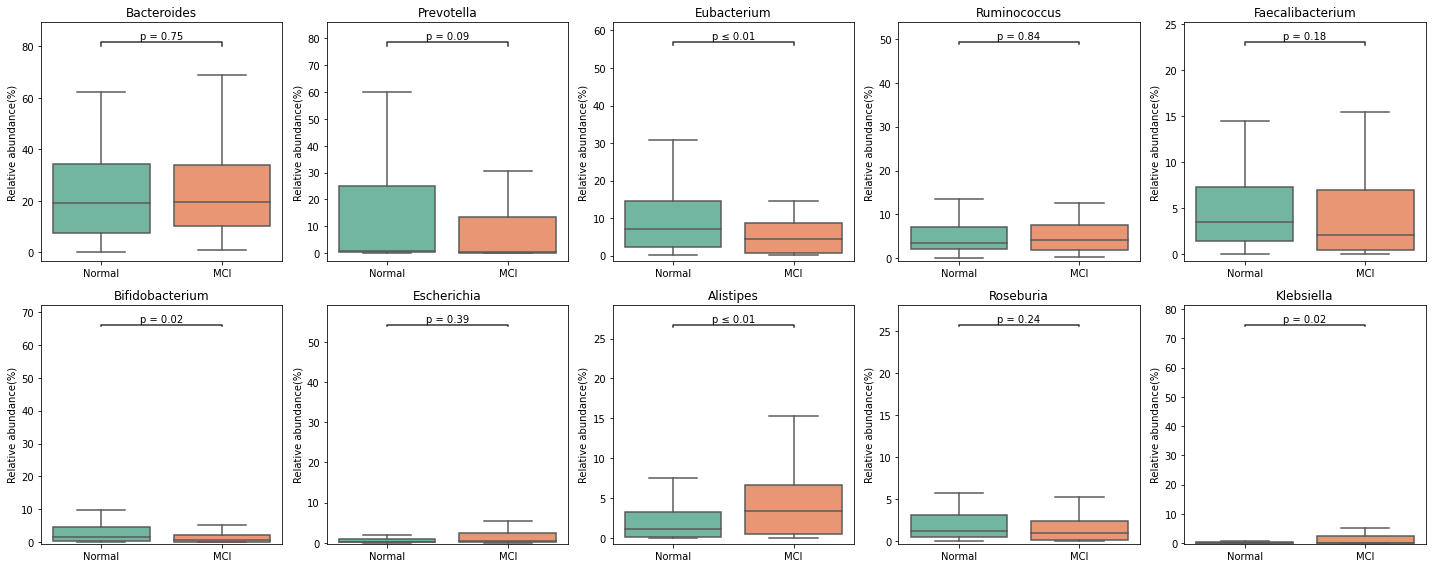

In [21]:
from statannot import add_stat_annotation

label_dict = dict(zip(metadata.index,metadata['Diagnosis'].values))
plot_df = genus_df.copy()
plot_df['Genus'] = plot_df.index
plot_df = plot_df.melt(id_vars='Genus')
plot_df.columns = ['Genus','Sample','Abundance']
plot_df['Diagnosis'] = plot_df['Sample'].map(label_dict)

fig, axes = plt.subplots(2,5,figsize = (20,8))
for idx,ax in enumerate(axes.ravel()) :
    genus_idx = np.where(plot_df['Genus'] == top10_g[idx],True,False)
    df = plot_df.loc[genus_idx,:]
    sns.boxplot(data=df, x='Diagnosis', y='Abundance',palette='Set2',order=['Normal','MCI'],ax = ax,showfliers = False)
    ax.set_title(top10_g[idx])
    ax.set_ylabel('Relative abundance(%)')
    ax.set_xlabel(None)
    add_stat_annotation(ax = ax,data=df, x='Diagnosis', y='Abundance',box_pairs=[("Normal", "MCI")],test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.tight_layout()
output_dir = '/home/bruce1996/data/MCI/result/taxonomy_composition/'
plt.savefig(output_dir + 'top_10_genus_boxplot.png',dpi = 300,bbox_inches = 'tight')

In [8]:
import plotly.express as px
import plotly.io as pio

condition = 'MCI'
idx = np.where(metadata['Diagnosis'] == condition,True,False)
plot_df = genus_df.loc[:,idx]

plot_df['Genus'] = plot_df.index
plot_df = plot_df.melt(id_vars='Genus')
plot_df.columns = ['Genus','Sample','Abundance']
order = np.array(genus_df.loc[top10_g[0],idx].sort_values(ascending=False).index)
genus_order = np.array(top10_g + ['Others'])

'''
label_dict = dict(zip(list(metadata.index),metadata['Diagnosis'].values))
plot_df['Diagnosis'] = plot_df['Sample'].map(label_dict)
'''
output_dir = '/home/bruce1996/data/MCI/result/taxonomy_composition/'
fig_title = 'Taxonomy composition of ' + condition + ' sample'
fig = px.bar(plot_df, x="Sample", y="Abundance", color="Genus",title=fig_title,width=1200, height=700,
             color_discrete_sequence=px.colors.qualitative.Set2,category_orders={"Genus": genus_order})
fig.update_layout(barmode='stack', xaxis={'categoryorder':'array', 'categoryarray':order}, title_x=0.5,yaxis_title="Relative abundance(%)")
#pio.write_image(fig,output_dir + 'taxonomy_composition_barplot_' + condition + '.png',format = 'png',scale = 2)
fig.show()

/tmp/ipykernel_885483/23767552.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### PERMANOVA

In [3]:
from permanova_between_cluster import *
from itertools import combinations

In [4]:
matrix = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/weighted_unifrac_distance_matrix.txt',sep = '\t',index_col=0)
matrix.columns = [x.split('_')[0] for x in matrix.index]
matrix.index = [x.split('_')[0] for x in matrix.index]
matrix = matrix.loc[metadata.index,metadata.index]

In [5]:
color_dict = dict()
cmap = cm.get_cmap('Set2', 8) 
n = 1
for idx,dia in enumerate(np.unique(metadata['Diagnosis'].values)):    
    rgba = cmap(idx)
    # rgb2hex accepts rgb or rgba
    color = colors.rgb2hex(rgba)
    color_dict[dia] = color

/home/bruce1996/anaconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.44386920604405966 and the largest is 8.065132881930582.
  warn(


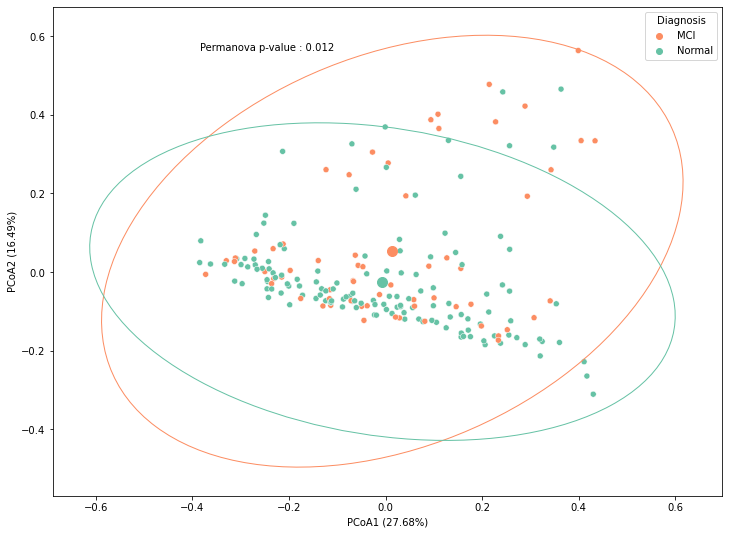

In [8]:
cb = list(combinations(np.unique(metadata['Diagnosis'].values),2))
plot_matrix = matrix.copy()
output_dir = '/home/bruce1996/data/MCI/result/taxonomy_composition/'

for i in range(len(cb)) :
    condition = cb[i]
    color = [color_dict[x] for x in condition]
    idx = np.where((metadata['Diagnosis'] == condition[0]) | (metadata['Diagnosis'] == condition[1]),True,False)
    m = plot_matrix.loc[idx,idx]
    label = metadata.loc[idx,:]
    title = ''
    file =  'permanova_' +str(condition[0]) + '_' + str(condition[1]) + '.png' 
    try :
        pcoa_with_permanova_scatterplot(m,label,hue='Diagnosis',condition=condition,title=title,output_path=file,color = ['#fc8d62','#66c2a5'],fig_size=(12,9))
    except Exception as e:
        print(e)

### LEFSE of MCI

In [9]:
df = pd.concat([metadata.T,meta_df])
df.to_csv('/home/bruce1996/data/MCI/metaphlan_result/lefse/lefse.txt',sep='\t')

In [10]:
lefse = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/lefse/lefse.res',sep='\t',header=None)

In [13]:
lefse.columns = ['Species','wilconox','class','LDA_score','kw']
lefse = lefse[lefse['LDA_score'] != '-']
lefse['LDA_score'] = [float(x) for x in lefse['LDA_score'].values]
lefse = lefse[lefse['LDA_score'] > 0.1]

In [15]:
lefse['Species'] = [x[3:].replace('_',' ') for x in lefse['Species'].values]

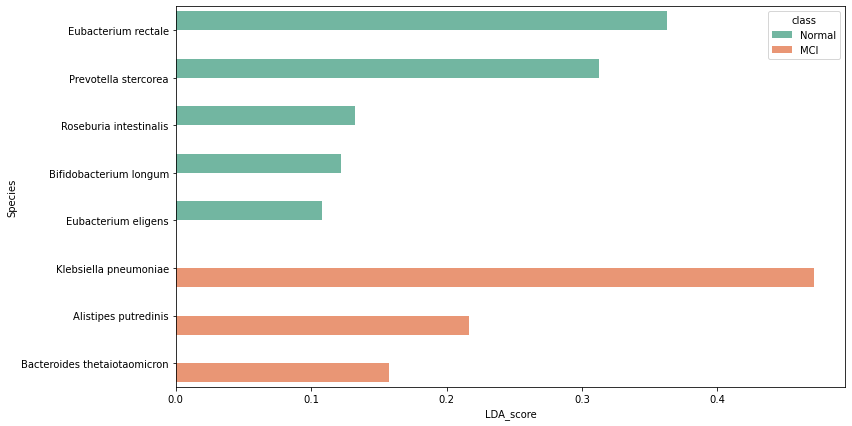

In [16]:
lefse = lefse.sort_values(by=['class','LDA_score'],ascending=False)
plt.figure(figsize=(12,7))
output_dir = '/home/bruce1996/data/MCI/result/taxonomy_composition/'
sns.barplot(data = lefse,x = 'LDA_score',y = 'Species',hue = 'class',palette='Set2')
plt.savefig('lefse_result.png',dpi = 300,bbox_inches = 'tight')

In [5]:
candidate_species = lefse['Species'].values
label_dict = dict(zip(metadata.index,metadata['Diagnosis'].values))
lefse_df = meta_df.loc[candidate_species,:]
lefse_df['Species'] = lefse_df.index
plot_df = lefse_df.melt(id_vars='Species')
plot_df.columns = ['Species','Sample','Abundance']
plot_df['Diagnosis'] = plot_df['Sample'].map(label_dict)

NameError: name 'metadata' is not defined

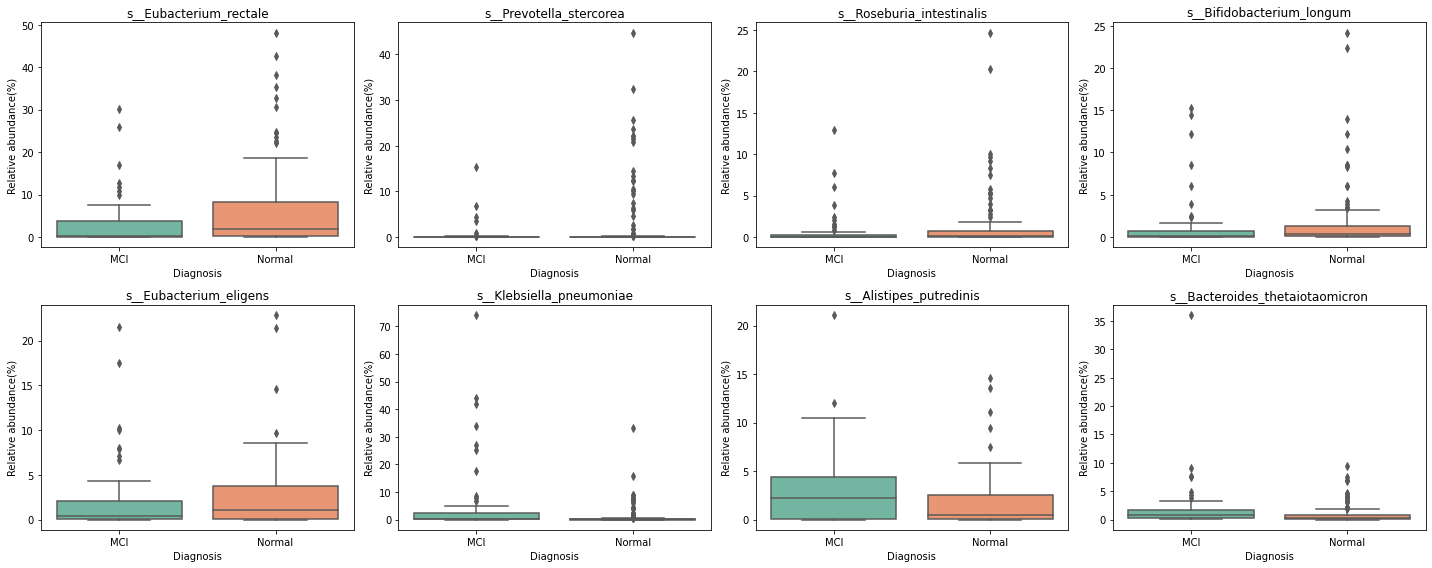

In [23]:
fig, axes = plt.subplots(2,4,figsize = (20,8))
for idx,ax in enumerate(axes.ravel()) :
    df = plot_df[plot_df['Species'] == candidate_species[idx]]
    sns.boxplot(data=df,x = 'Diagnosis',y='Abundance',palette='Set2',ax=ax,showfliers = True)
    ax.set_title(candidate_species[idx])
    ax.set_ylabel('Relative abundance(%)')
fig.tight_layout()
plt.savefig(output_dir + 'lefse_candidate_species_boxplot_with_outlier.png',dpi = 300)

### Taxonomy set enrichment analysi

In [11]:
from utils.tsea import *

In [12]:
humann_df = pd.read_csv('/home/bruce1996/data/MCI/raw_data/humann_output/merge_mci_humann_pathabundance.txt',sep='\t',index_col=0)
idx = [bool(re.search('UNMAPPED|UNINTEGRATED',x)) == False for x in humann_df.index]
humann_df = humann_df.loc[idx,:]
humann_df.columns = [x.split('-')[0] for x in humann_df.columns]

In [ ]:
idx = [bool(re.search('\|',x)) == False for x in humann_df.index]
pathway = list(humann_df.index[idx])
pathway_species = dict()
candidate_species = list(meta_df.index)
missing = []
for path in pathway :
    print(path)
    try :
        idx = [bool(re.search(path + '\|',x)) for x in humann_df.index]
        candidate = [x.split('|')[-1] for x in humann_df.index[idx]]
        for c in candidate :
            if c == 'unclassified' :
                pass
            else :
                species = c.split('.')[-1]
                if species not in candidate_species :
                    pass
                else :
                    if path not in pathway_species.keys() :
                        pathway_species[path] = [species]
                    else :
                        pathway_species[path].append(species)
    except :
        missing.append(path)

In [10]:
idx = [bool(re.search('PWY-7388',x)) for x in humann_df.index]
candidate = humann_df.index[idx][1:-2]
path = 'PWY-7388: octanoyl-acyl-carrier protein biosynthesis (mitochondria, yeast)'
for c in candidate :
    species = c.split('.')[-1]
    if species not in candidate_species :
        pass
    else :
        if path not in pathway_species.keys() :
            pathway_species[path] = [species]
        else :
            pathway_species[path].append(species)

NameError: name 'humann_df' is not defined

In [13]:
import pickle
with open('pathway_species.pkl','rb') as f:
    pathway_species = pickle.load(f)
f.close()

In [14]:
deseq = pd.read_csv('/home/bruce1996/data/MCI/result/taxonomy_composition/species_deseq2_by_MCI.txt',sep='\t',index_col=0)
ranking = list(deseq.sort_values(by='log2FoldChange',ascending=False).index)
mci_tsea = taxonomy_set_enrichment_analysis(cluster_component=pathway_species,ranking=ranking)
mci_tsea.tsea()

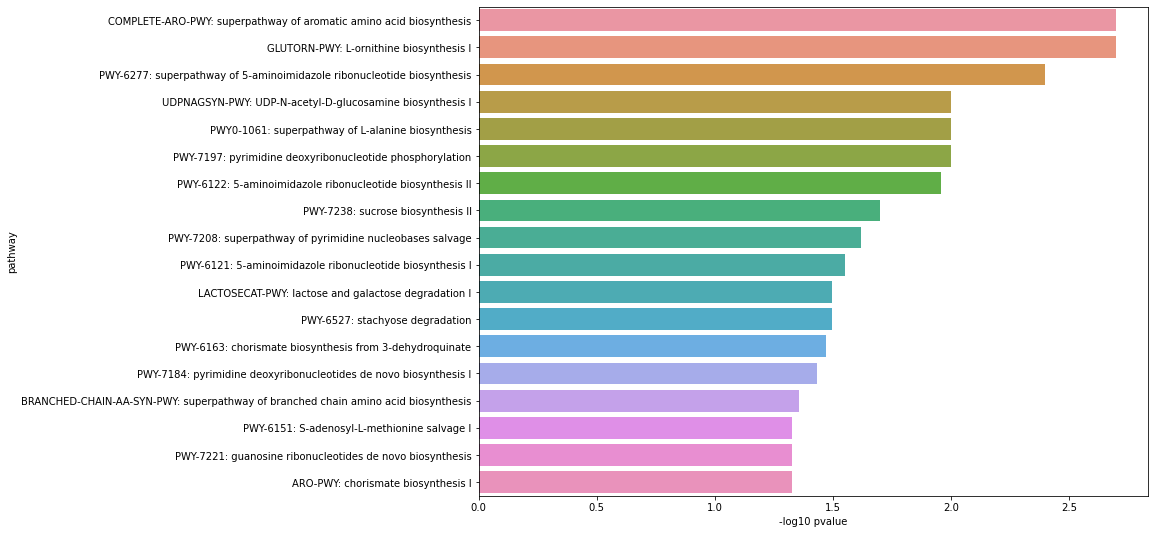

In [15]:
from math import log10
df = pd.DataFrame({'pathway' : list(mci_tsea.cluster_component.keys()) , 'pesudo-F' : mci_tsea.pesudo_f})
plot_df = df[df['pesudo-F'] < 0.05].sort_values(by='pesudo-F')
plot_df['pesudo-F'] = [-1 * log10(x) for x in plot_df['pesudo-F'].values]

plt.figure(figsize=(12,9))
sns.barplot(data= plot_df,x = 'pesudo-F',y = 'pathway')
plt.xlabel('-log10 pvalue')
output_dir = '/home/bruce1996/data/MCI/result/taxonomy_composition/'
plt.savefig(output_dir + 'humann_mci_species_tsea_result.png',dpi = 300,bbox_inches = 'tight')